# **Mushroom Binary Classification** - John Lopez
## **Introduction and Data Description**
#### This data set was retrieved from kaggle.com : https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset/data. 
Machine learning is a universally useful tool in that it can be effective in a diverse range of situations. For instance, say you have thousands and thousands of mushrooms for food, but have no clue which ones are edible and which ones are poisonous. How would you go about figuring out which ones are gonna harm you or help you? Instead of trying them out one by one and hoping for the best, just make a neural network and let it do the work for you!

In this project, I designed a neural network that is trained on a dataset of different mushroom characteristics, and can determine which mushroom is poisonous or edible based on those characteristics. This dataset contains 54,035 entries each with 9 parameters to describe each mushroom:
1. Cap Diameter
2. Cap shape
3. Gill Attachment
4. Gill color
5. Stem Height
6. Stem Width
7. Stem Color
8. Season
9. The target class: Edible or poisonous.

The parameters that are more descriptive (i.e. color/shape/attachment) are represented with a a different number for the different classes within that parameter. For instance gill-color posseses integers between 0 to 11. The target class contains two values, 0 or 1, for 'edible' and 'poisonous' respectively.

### Import necessary modules.
Let's start by importing the tools we need for the project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Read in the data.
### **Change your file path to where you saved the dataset.**
Next let's take a peek at the data.

In [2]:
# Set file path.
filepath = "mushroom_cleaned.csv"

data = pd.read_csv(filepath) # Read in data.
data.head()                  # Print headers.

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [3]:
# Print info on dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB


### **Preprocessing**
Let's clean up the data a little bit. First we need to check if there are any missing values in the columns.

In [4]:
# Quantify if there are any empty entries in the dataset.
data.isnull().sum()

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64

Looks like we are all set there. Next, we can further refine the dataset by removing any large outliers. We do this by looking at their "Z-Score," which describes a value's position relative to the mean of a group of values. The formula for calculating the z-score of a value x is:
$$ z = \frac{x - \mu}{\sigma}$$
Where $\mu$ is the data mean and $\sigma$ is the data standard deviation. A Z-score of 0 means the data value is equal to the mean, a positive Z-score means it is above the mean, and a negative Z-score means it is below the mean.

In [5]:
# Calculate the Z-scores.
z_scores_data = {}
for column in data.drop(columns=['class']).columns:
    z_scores_data[column] = (data[column] - data[column].mean())/ data[column].std()

# Create a separate data frame containing the Z-scores.
z_scores_df = pd.DataFrame(z_scores_data)

In [6]:
z_scores_df

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season
0,2.236119,-0.925855,-0.063736,0.834459,4.682802,0.631564,0.791501,2.788376
1,2.483421,-0.925855,-0.063736,0.834459,4.682802,0.646908,0.791501,2.788376
2,2.233340,-0.925855,-0.063736,0.834459,4.383293,0.658417,0.791501,2.788376
3,1.927686,0.925564,-0.063736,0.834459,4.652240,0.658417,0.791501,2.788376
4,2.049947,0.925564,-0.063736,0.834459,4.536104,0.527991,0.791501,-0.029347
...,...,...,...,...,...,...,...,...
54030,-1.373380,0.462709,0.384932,-1.665333,0.197599,-0.616428,1.098054,-0.029347
54031,-1.348372,-0.925855,0.384932,-1.665333,0.656029,-0.717444,1.098054,-0.029347
54032,-1.348372,0.462709,0.384932,-1.665333,0.240385,-0.597248,1.098054,-0.208488
54033,-1.356708,-0.925855,0.384932,-1.665333,0.423758,-0.716165,1.098054,-0.208488


In [7]:
z_scores_df.abs().max()

cap-diameter       3.678251
cap-shape          1.851564
gill-attachment    1.730935
gill-color         2.290281
stem-height        4.725589
stem-width         3.219614
stem-color         2.580583
season             3.026211
dtype: float64

It looks like there are 4 columns that possess values with absolute Z-scores greater than 3. This is significant because ~99% of normally distributed data falls in a z-score range of -3.0 to 3.0. Let's remove these outlier data points.

In [8]:
# Isolate and remove the outlier data points by identifying their index.
data_outliers = z_scores_df[(np.abs(z_scores_df) > 3).any(axis=1)]
data_cleaned = data.drop(data_outliers.index)

In [9]:
print("Number of outliers removed:")
print(f"{data.shape[0]} Original Entries - {data_outliers.shape[0]} Outliers = {data_cleaned.shape[0]} Remaining Entries")

Number of outliers removed:
54035 Original Entries - 3638 Outliers = 50397 Remaining Entries


Looks like only about ~3600 outliers were in the data.

## Visualize the data.
Let's get an idea of what our data looks like now that we cleaned it up.

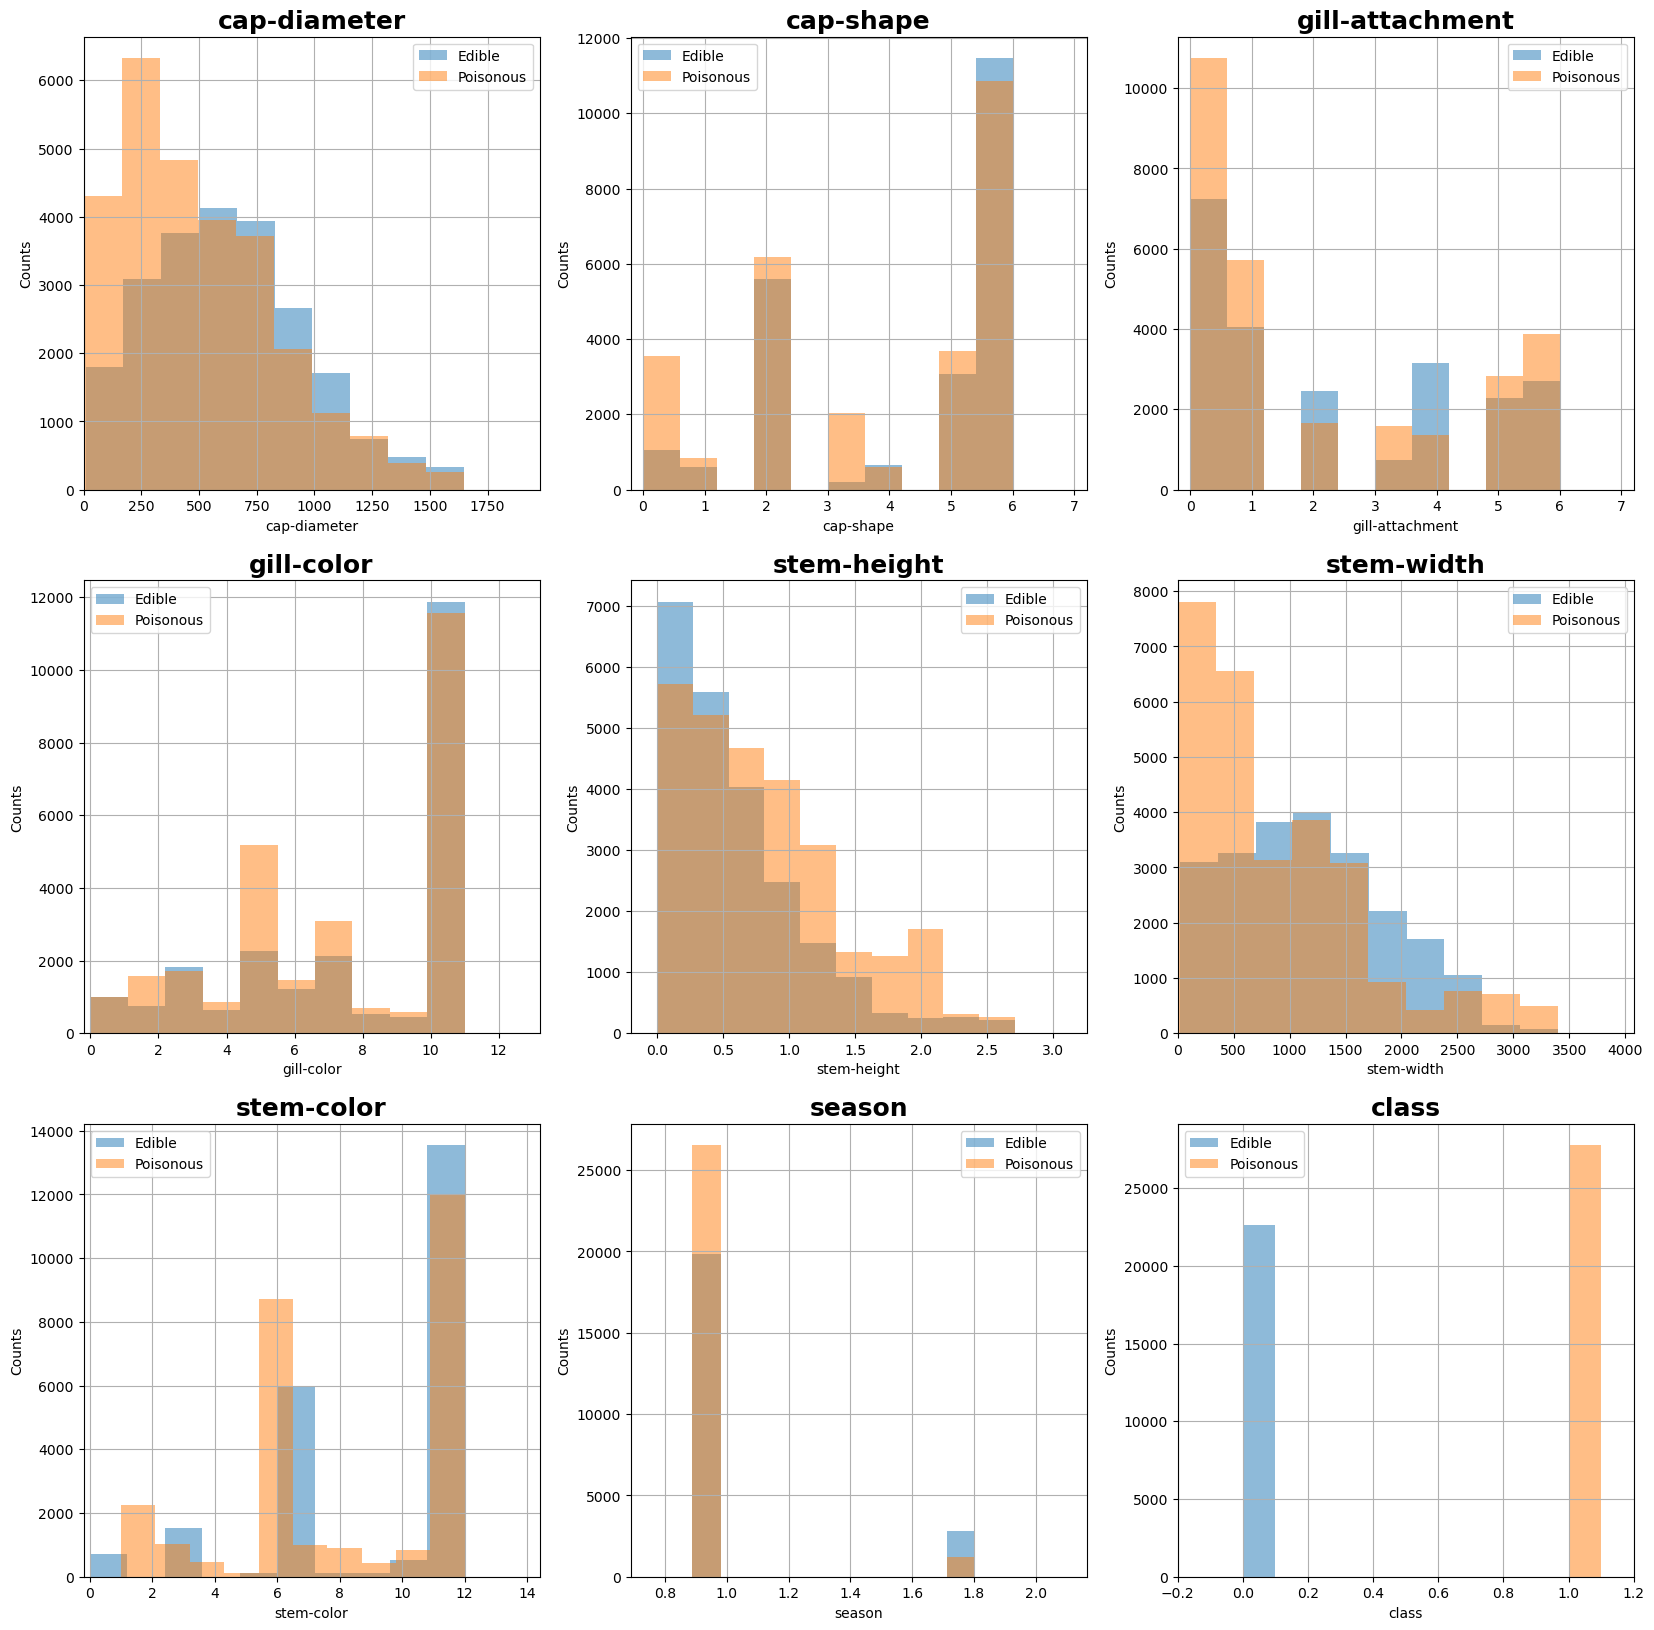

In [10]:
# Plot the parameters and target class distributions.

# Initialize the plots.
fig,axes = plt.subplots(3,3, figsize=(20,20))
axes = axes.ravel()

# Iterate through the columns and plot the respective data. Create two overlaying distributions
# for 'edible' and 'poisonous' classes.
for i in range(9):
    column = data_cleaned.columns[i]
    axes[i].hist(data_cleaned[data_cleaned.iloc[:,8] == 0][column], alpha=0.5, label = 'Edible')
    axes[i].hist(data_cleaned[data_cleaned.iloc[:,8] == 1][column], alpha=0.5, label = 'Poisonous')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Counts')
    axes[i].set_title(column, fontweight='bold', fontsize=18)
    axes[i].legend()
    axes[i].grid()
    axes[i].set_xlim(data_cleaned[column].min() - 0.2
                     , data_cleaned[column].max()*1.2)

plt.show()

It looks like population between edible and poisonous mushrooms are roughly equal, with slightly more poisonous mushrooms in the total population. We can also already see some interesting trends in the other parameters.

## Standardize the data.
Using the Z-scores calculated earlier, we can create a dataframe consisting of standardized data. This way, all features are on a similar scale which will help prevent larger scale features from influencing the learning model too heavily. We can also define our training set and the target set.

In [11]:
# Create the standardized data. Drop the outliers found earlier.
data_standard = z_scores_df.drop(data_outliers.index)

X_stand = data_standard.values # Training set.
T_stand = data[data.index.isin(data_standard.index)]['class'].values # Target set.

X = X_stand
T = T_stand

## **Methodology**

Since this data set consists of multiple parameters we wish to use to differentiate each mushroom into two different classes, I decided to employ a multilayer perceptron (MLP) since this enables the modeling of complex relationships in the data that are not linearly obvious. To increase the accuracy of the model I used three hidden layers to try and identify more complex patterns. However, overfitting became a concern so dropout layers were added. Essentially, these dropout layers provide a chance for neurons in the network to randomly be dropped (set to 0). I set a probability of 0.5. Introducing randomness into the model helps negate overfitting during the training process. Batch normalization was implemented to help improve convergence rate during training by reducing the internal covariate shift. Basically, during training the distribution of inputs in each layer may change as parameters are updated, so batch normalization normalizes the inputs of each layer. Since this is a binary classification problem, I decided to use a sigmoid activation function, as this is optimal for logistic regression. BCELoss was chosen for the criterion as this is a binary classification problem. "Adam" was chosen as the optimizer as it implements an adapting learning rate, permitting more flexibility as opposed to the "SGD" optimizer used in the homework, which maintains a constant learning rate. 

To generate the testing and training sets, I used sklearn's train_test_split() function. This function takes the input data, target data, and the fraction portion of the input data to split into test data, along with a random state for reproducable shuffling of the data before the split.

In [12]:
# Generate testing and training sets using sklearn's train_test_split().
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2, random_state=27)

# Create the training and testing tensors. ".unsqueeze(1)" transforms the target tensors from 1D
# to 2D of N x 1 size.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
T_test_tensor = torch.tensor(T_test, dtype=torch.float32).unsqueeze(1)

# Define the 3-layered logistic regression model.
class MushClassifier(nn.Module):  # Chatgpt helped some with designing the layers and optimization.
    """
    A 3-layered logistic regression model for binary classification.
    """
    def __init__(self, input_dim):
        """
        Initialize the MushClassifier model.
        """
        super(MushClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100) # First hidden layer.
        self.bn1 = nn.BatchNorm1d(100) # First batch normalization.
        
        self.layer2 = nn.Linear(100, 50) # Second.
        self.bn2 = nn.BatchNorm1d(50)
        
        self.layer3 = nn.Linear(50, 20) # Third.
        self.bn3 = nn.BatchNorm1d(20)
        
        self.output = nn.Linear(20, 1) # Output layer.
        self.sigmoid = nn.Sigmoid() # Sigmoid activation function.
        self.dropout = nn.Dropout(p = 0.5) # Employ dropout.

    def forward(self, x): # Chatgpt helped some with designing the layers and optimization.
        """
        Performs the forward pass through the MushClassifier model.
        Input:
            x (torch.tensor): The input tensor.
        Output:
            (torch.tensor): Output tensor of predicted probabilities.
        """
        x = torch.relu(self.bn1(self.layer1(x))) # Activation after first hidden layer.
        x = self.dropout(x) # First dropout layer.
        
        x = torch.relu(self.bn2(self.layer2(x))) # Second activation.
        x = self.dropout(x) # Second dropout.
        
        x = torch.relu(self.bn3(self.layer3(x))) # Third activation.
        x = self.dropout(x) # Third dropout.
        
        x = self.output(x) # Linear transformation at output layer
        x = self.sigmoid(x) # Sigmoid activation at output
        return x

# Define the input dimensions and intialize the model.
input_dim = X_train.shape[1]
model = MushClassifier(input_dim)

## TRAINING
Now we can train the model.

In [13]:
print('>>>TRAINING MODEL<<<')
# Chatgpt provided some insight in how to write the training loop. Primarily on how to organize each step.

# Initialize the model, loss function, and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer.
# optimizer = optim.SGD(model.parameters(), lr=0.001) # Uncomment to try with the SGD optimizer.


# Train the model
num_epochs = 1000 # Number of epochs

# Initialize empty lists to store the loss and accuracy history.
loss_hist = []
accuracy_hist = []

# Iterate through epochs and perform the training.
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass for training data
    outputs = model(X_train_tensor)
    loss = criterion(outputs, T_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    loss_hist.append(loss.item()) # Append loss history of training data
    optimizer.step()

    # Evaluate the accuracy of the model.
    model.eval()
    with torch.no_grad():
        
        predictions = model(X_train_tensor)
        predicted_classes = (predictions.numpy() > 0.5).astype(int)
        accuracy = accuracy_score(T_train, predicted_classes)
        accuracy_hist.append(accuracy)

    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Print the final accuracy.
print(f'Accuracy: {accuracy_hist[-1]:.4f}')

>>>TRAINING MODEL<<<
Epoch [100/1000], Loss: 0.5863
Epoch [200/1000], Loss: 0.5342
Epoch [300/1000], Loss: 0.4740
Epoch [400/1000], Loss: 0.4048
Epoch [500/1000], Loss: 0.3477
Epoch [600/1000], Loss: 0.3271
Epoch [700/1000], Loss: 0.3109
Epoch [800/1000], Loss: 0.3021
Epoch [900/1000], Loss: 0.2950
Epoch [1000/1000], Loss: 0.2912
Accuracy: 0.9356


## TESTING
Now lets test the model.

In [14]:
print('>>>TESTING MODEL<<<')
# Chatgpt provided some insight in how to write the testing loop. Primarily on how to organize each step.

# Initialize the model, loss function, and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer.
# optimizer = optim.SGD(model.parameters(), lr=0.001) # Uncomment to try with the SGD optimizer.

# Test the model
num_epochs = 1000 # Number of epochs.

# Initialize empty lists to store the loss and accuracy history.
loss_hist_test = []
accuracy_hist_test = []

# Iterate through the epochs and perform the testing.
model.eval()
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    
    # Forward pass for testing data
    outputs = model(X_test_tensor)
    loss = criterion(outputs, T_test_tensor)
    
    # Backward pass and optimization
    loss.backward()
    loss_hist_test.append(loss.item()) # Append loss history of testing data
    optimizer.step()

    # Evaluate the accuracy of the test.
    accuracy = 0
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predicted_classes = (predictions > 0.5).float() # Convert to float tensor
        correct_predictions = (predicted_classes == T_test_tensor).sum().item()
        accuracy = correct_predictions / len(T_test_tensor)
        accuracy_hist_test.append(accuracy)

    # Print the loss every 100 epochs.
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Print the final accuracy.
print(f'Accuracy: {accuracy_hist_test[-1]:.4f}')

>>>TESTING MODEL<<<
Epoch [100/1000], Loss: 0.0143
Epoch [200/1000], Loss: 0.0091
Epoch [300/1000], Loss: 0.0068
Epoch [400/1000], Loss: 0.0053
Epoch [500/1000], Loss: 0.0043
Epoch [600/1000], Loss: 0.0037
Epoch [700/1000], Loss: 0.0032
Epoch [800/1000], Loss: 0.0029
Epoch [900/1000], Loss: 0.0027
Epoch [1000/1000], Loss: 0.0025
Accuracy: 0.9988


We can see some exceptionally high accuracies and relatively low loss.! Lets visualize the loss and accuracy.

## Visualization
Lets start with the loss history from both the training and testing loops.

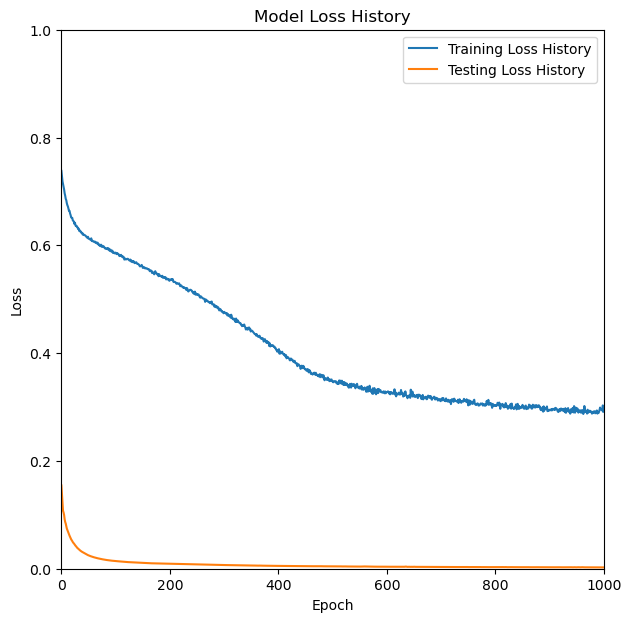

In [15]:
# Loss history plot.
plt.figure(figsize=(7,7))
x_range = np.arange(num_epochs)
plt.plot(x_range, loss_hist, label='Training Loss History')
plt.plot(x_range, loss_hist_test, label = 'Testing Loss History')
plt.ylim(0,1.0)
plt.xlim(0,num_epochs)
plt.title("Model Loss History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

And the accuracy.

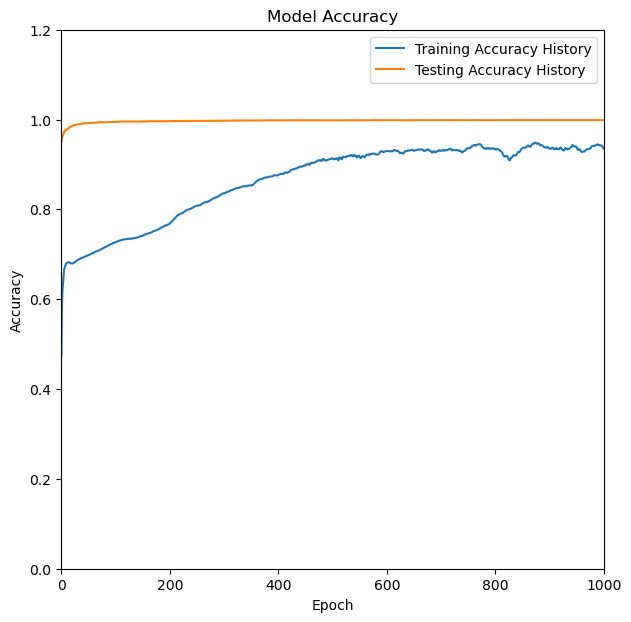

In [16]:
# Model accuracy plot.
plt.figure(figsize=(7,7))
x_range = np.arange(num_epochs)
plt.plot(x_range, accuracy_hist, label='Training Accuracy History')
plt.plot(x_range, accuracy_hist_test, label='Testing Accuracy History')
plt.ylim(0,1.2)
plt.xlim(0, num_epochs)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## **Discussion and Conclusion**

To recap the project, I created a binary classification model in the form of a multilayer perceptron with logistic regression in order to classify poisonous or edible mushrooms depending on 8 of their characteristics.

The MushClassifier showed around 95% in training and an astounding 99% accuracy in testing (These accuracies vary slightly with each run as testing/training split sets are randomized). In other words, theres a good chance of avoiding a stomch ache or worse if you use this model to determine if a mushroom is edible or not. However, the loss history plot does not show clear convergence. This could be solved with more epochs, however adding a couple thousand epochs would drastically increase the running time of the code.

When designing this model, I tested an alternate, simpler version that showed over 90% accuracy with z-score cleaning, and about 70% accuracy without z-score cleaning:

In [17]:
# # Define the logistic regression model with multiple layers
# class MushroomClassifier(nn.Module):
#     def __init__(self, input_dim):
#         super(MushroomClassifier, self).__init__()
#         self.layer1 = nn.Linear(input_dim, 100)
#         self.layer2 = nn.Linear(100, 50)
#         self.layer3 = nn.Linear(50, 20)
#         self.output = nn.Linear(20,1)
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         x = torch.relu(self.layer1(x))
#         x = torch.relu(self.layer2(x))
#         x = torch.relu(self.layer3(x))
#         x = self.output(x)
#         x = self.sigmoid(x)
#         return x

This could mean either my current model is a bit too unneccesarily powerful for the task at hand, or the outliers that z-score cleaning removed really swayed the results. Regardless, this model can be applied to other, more challenging tasks with some tweaks. This could include determining what type of nutritional qualities a mushroom could have when given its characteristics (i.e. vitamins, protein amount, medicinal qualities, e.t.c.). This would require more descriptive parameters like color patterns on the cap, regions they grow in, data on their preferred encvironment, e.t.c. Since classification problems are extremely common, this same model could be applied to entirely unrelated data sets containing lists of parameters with 2 target classification outcomes.

Through this project I learned more about neural networks and multilayer perceptrons, as well as how to structure ML models. I feel like I have developed the foundational skills and knowledge to continue developing stronger and more elaborate models.

Chatgpt use:
I had chatgpt explain definitions, methods used in ML, how binary classification problems can be approached, and methods on improving accuracy. I also had help with parts of the training and testing loops, as well as the layering of the model.